# Description

Files used: [htru2_pulsar_data](./Data/htru2/HTRU_2.csv), [htru2_pulsar_data_arff](./Data/htru2/HTRU_2.csv) <br>

# Loading Data

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import seaborn as sb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score, KFold, train_test_split
from sklearn.metrics import confusion_matrix
from types import SimpleNamespace
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [4]:
arffFilePath = './Data/htru2/HTRU_2.arff'
columnNames = []
with open(arffFilePath) as myfile:
    for i in range(20):
        arffLine = next(myfile).strip().split()
        if (arffLine[0] == '@attribute'):
            columnNames.append(arffLine[1])
            continue
        elif (arffLine[0] == '@data'):
            break
print(columnNames)

['Profile_mean', 'Profile_stdev', 'Profile_skewness', 'Profile_kurtosis', 'DM_mean', 'DM_stdev', 'DM_skewness', 'DM_kurtosis', 'class']


In [6]:
dataFilePath = './Data/htru2/HTRU_2.csv'

dataset = pd.read_csv(dataFilePath, names=columnNames)
dataset

,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis,class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0
...,...,...,...,...,...,...,...,...,...
17893,136.429688,59.847421,-0.187846,-0.738123,1.296823,12.166062,15.450260,285.931022,0
17894,122.554688,49.485605,0.127978,0.323061,16.409699,44.626893,2.945244,8.297092,0
17895,119.335938,59.935939,0.159363,-0.743025,21.430602,58.872000,2.499517,4.595173,0
17896,114.507812,53.902400,0.201161,-0.024789,1.946488,13.381731,10.007967,134.238910,0


# Data Statistics

In [7]:
dataset.shape

(17898, 9)

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Profile_mean      17898 non-null  float64
 1   Profile_stdev     17898 non-null  float64
 2   Profile_skewness  17898 non-null  float64
 3   Profile_kurtosis  17898 non-null  float64
 4   DM_mean           17898 non-null  float64
 5   DM_stdev          17898 non-null  float64
 6   DM_skewness       17898 non-null  float64
 7   DM_kurtosis       17898 non-null  float64
 8   class             17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


In [9]:
dataset.describe(include='all')

,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis,class
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309330,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392141,110.642211,34.539844,1191.000837,1.000000


In [10]:
dataset.isnull().sum()

Profile_mean        0
Profile_stdev       0
Profile_skewness    0
Profile_kurtosis    0
DM_mean             0
DM_stdev            0
DM_skewness         0
DM_kurtosis         0
class               0
dtype: int64

In [11]:
dataset.duplicated(keep='first').sum()

0

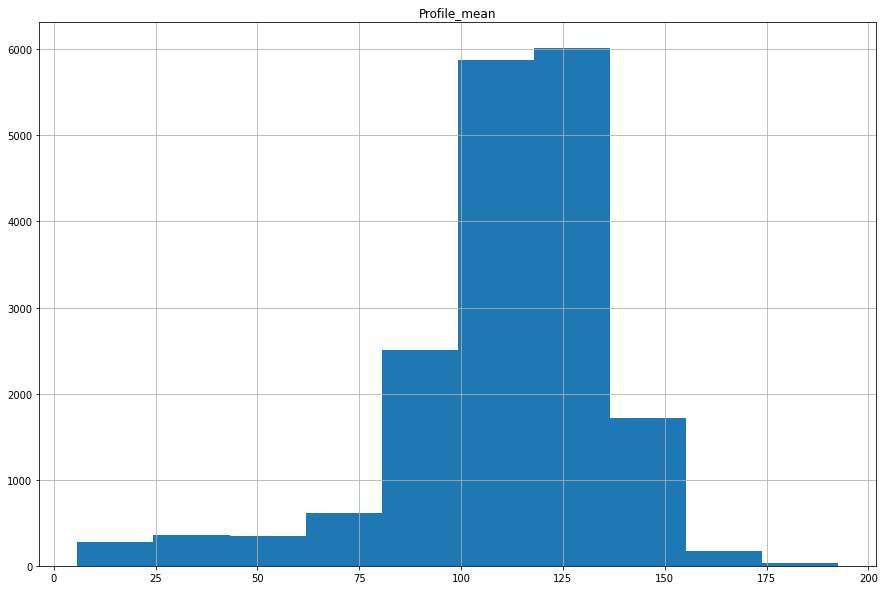

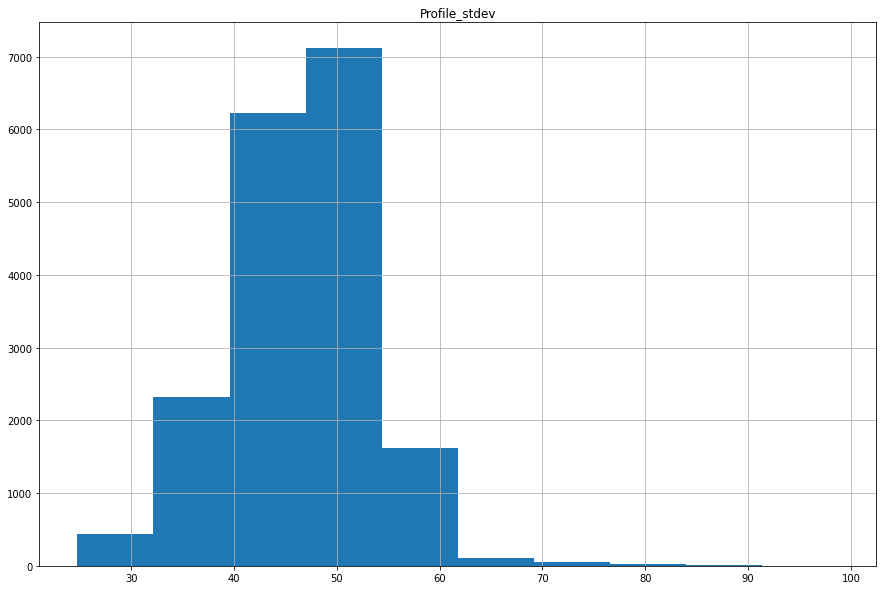

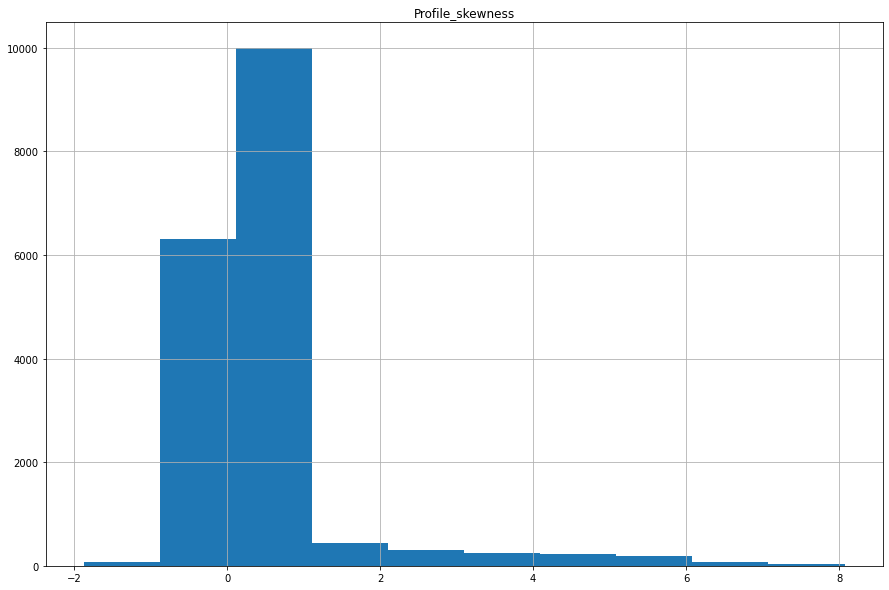

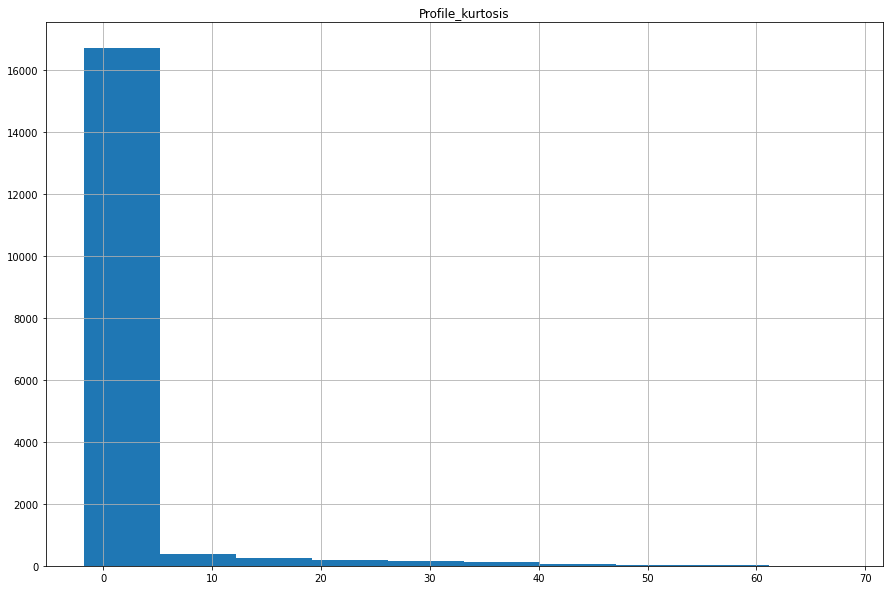

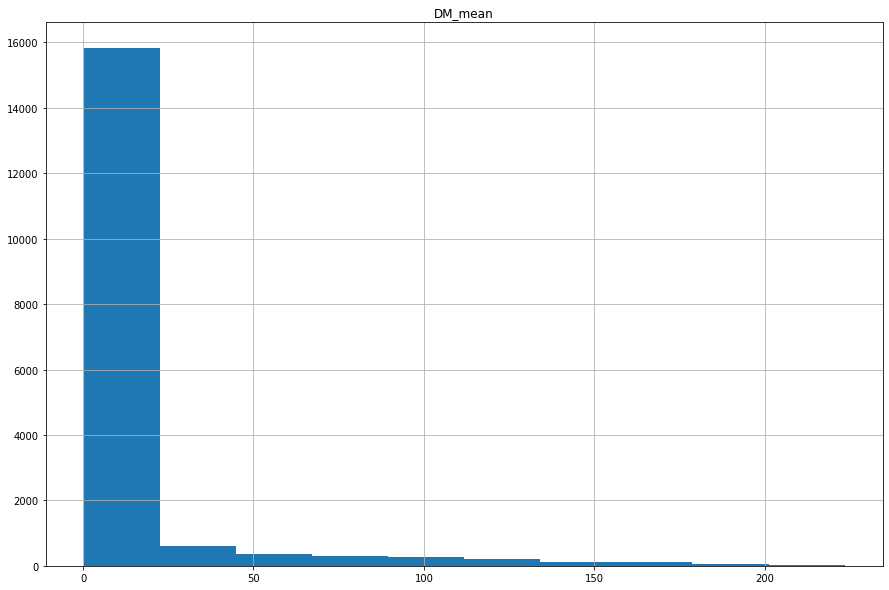

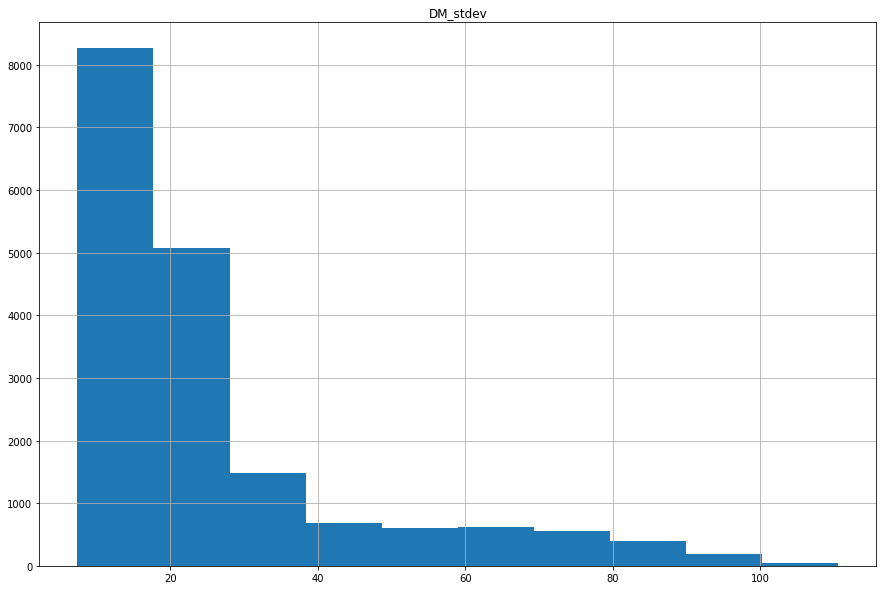

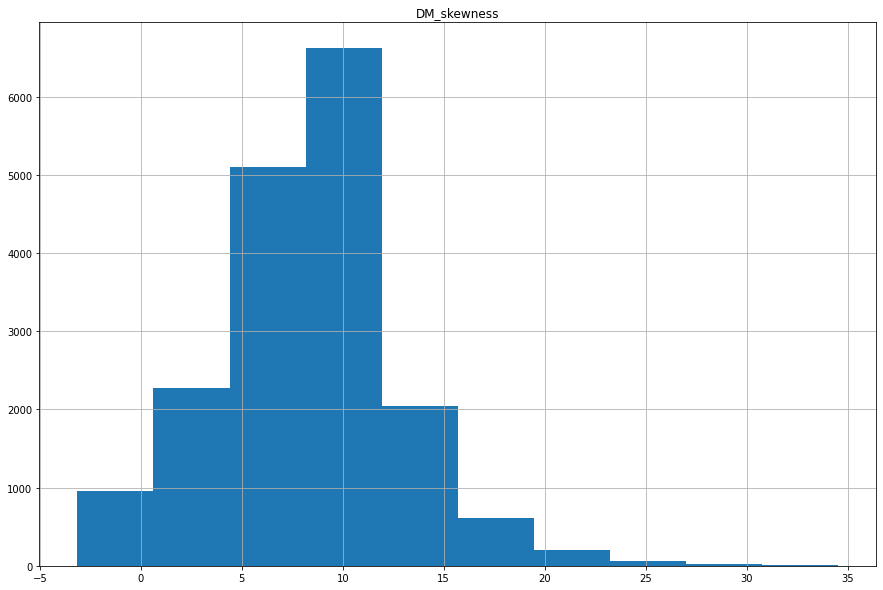

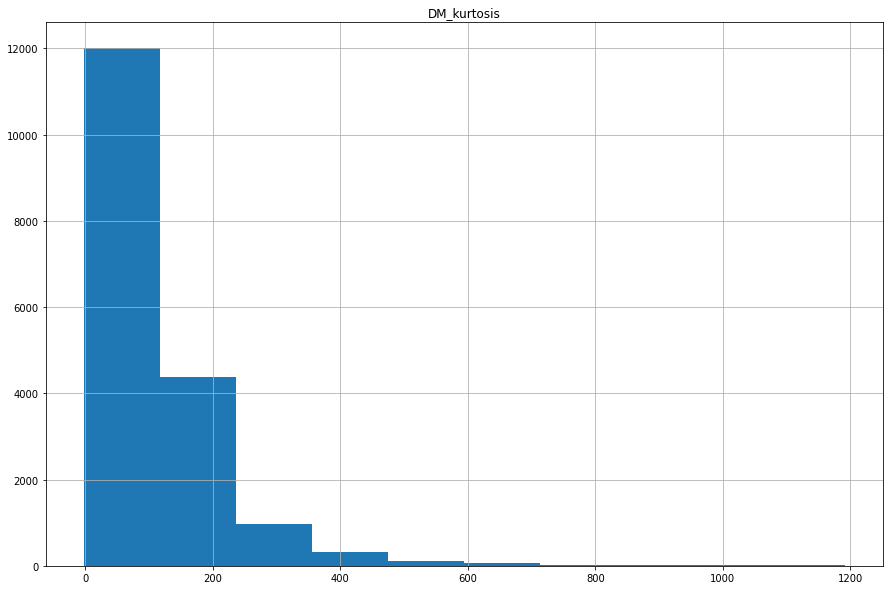

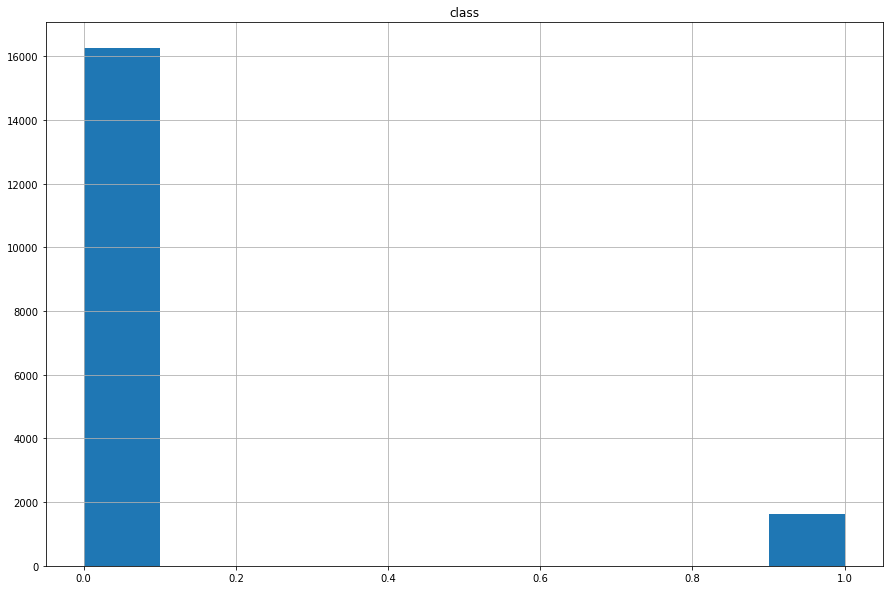

In [17]:
datasetClass = dataset['class']
datasetFeatures = dataset.loc[:, dataset.columns != 'class']
features = dataset.loc[:, dataset.columns != 'class']
categoricFeaturesList = list(dataset.dtypes[dataset.dtypes == object].index)
numericFeaturesList = list(dataset.dtypes[dataset.dtypes != object].index)
for column in dataset.columns:
    if (dataset.dtypes[column].name.__eq__('object')):
        sb.catplot(x=column, kind='count', data=dataset, height=10, aspect=2)
    else:
        dataset.hist(column=column, figsize=[15,10])

## Correlation

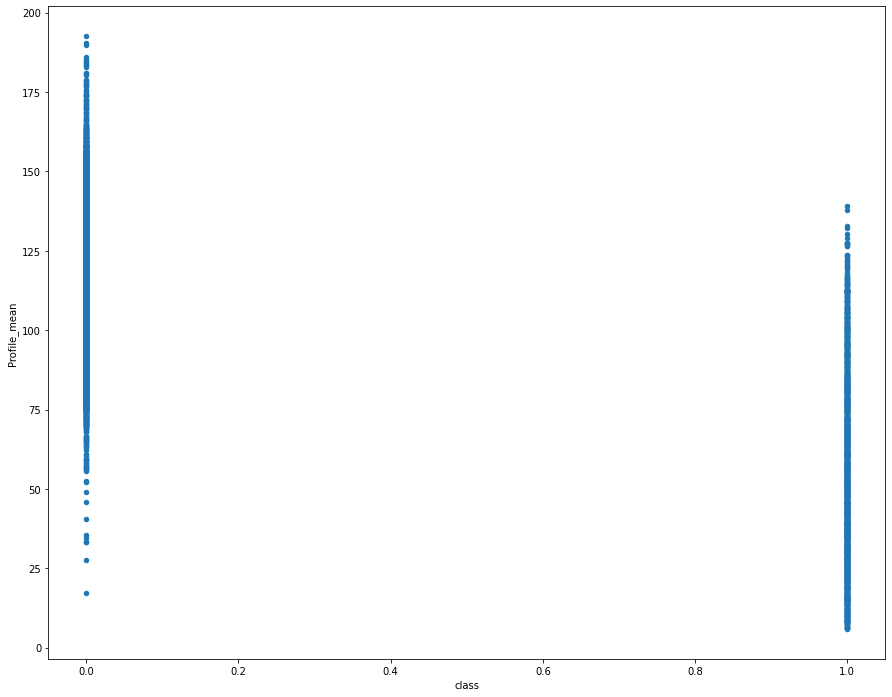

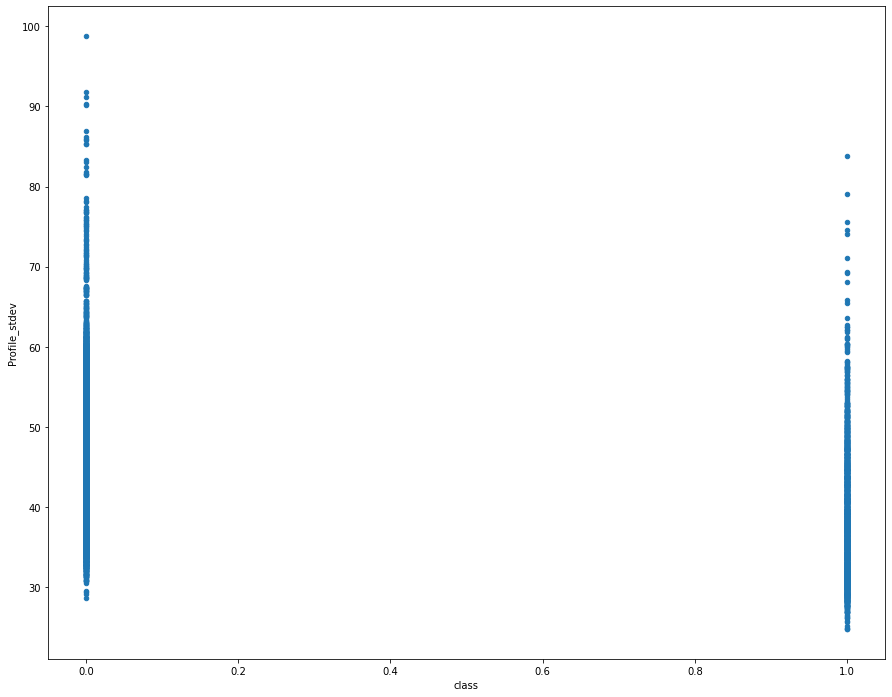

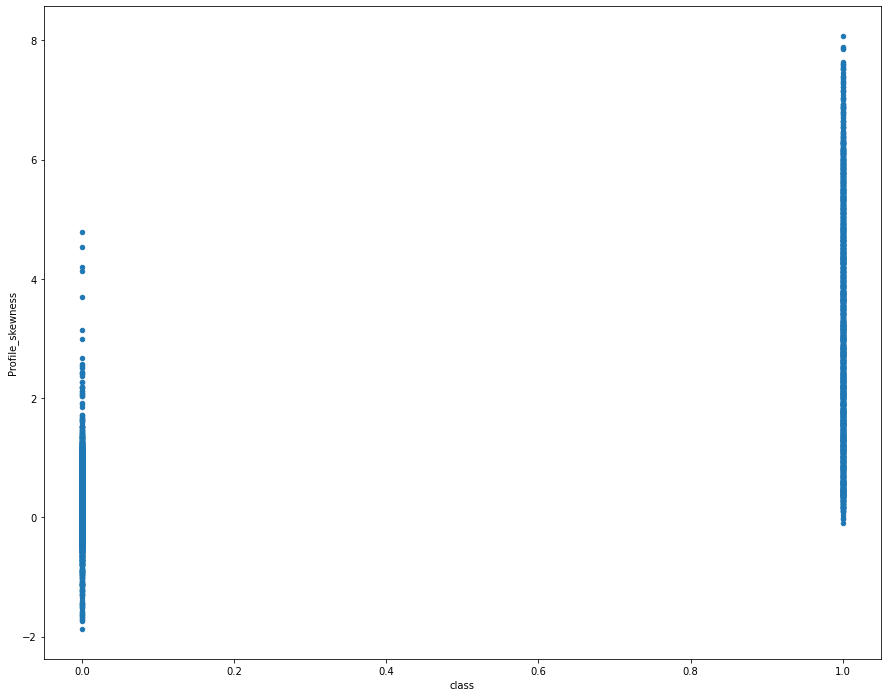

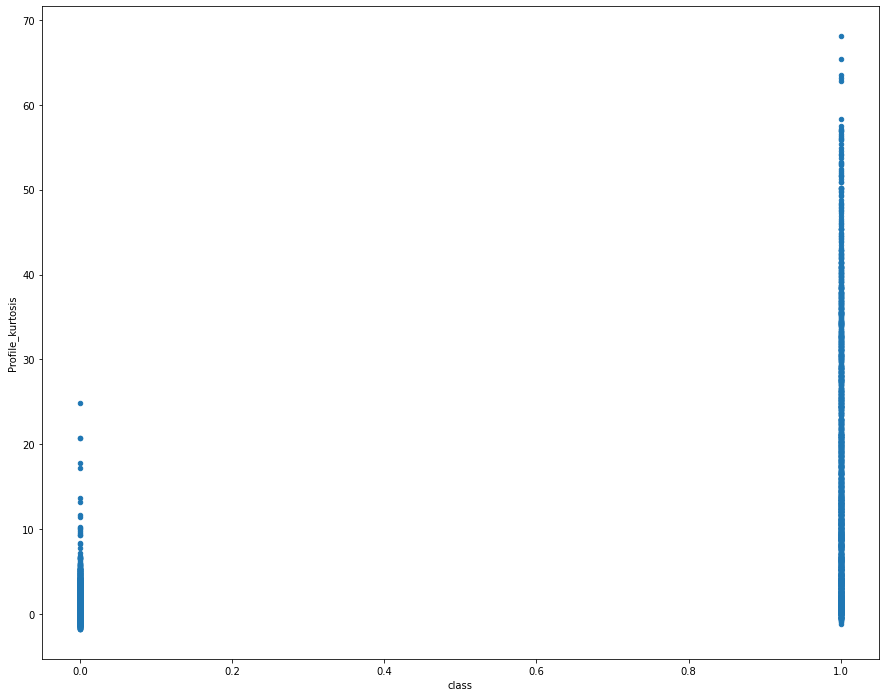

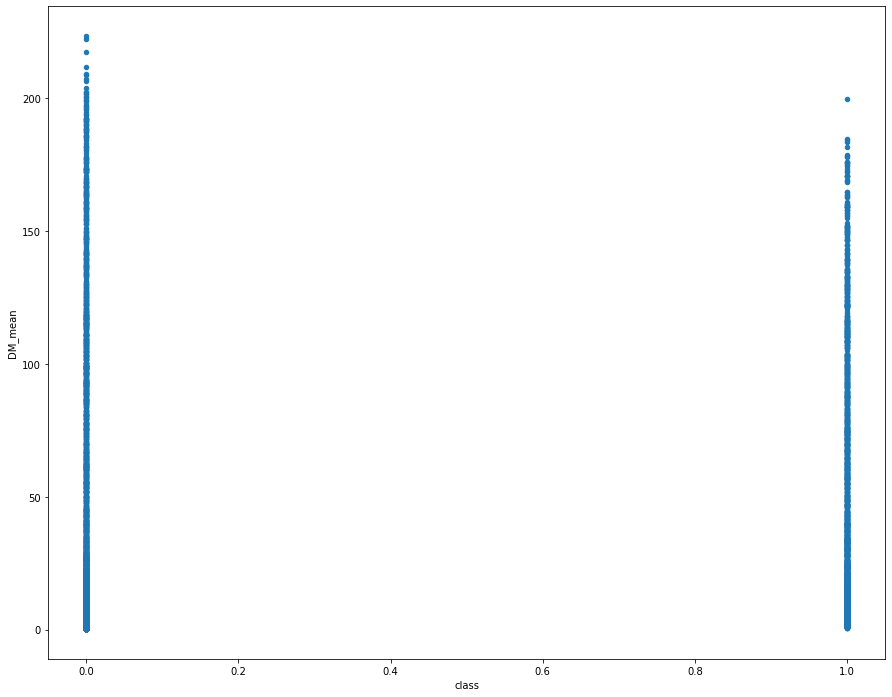

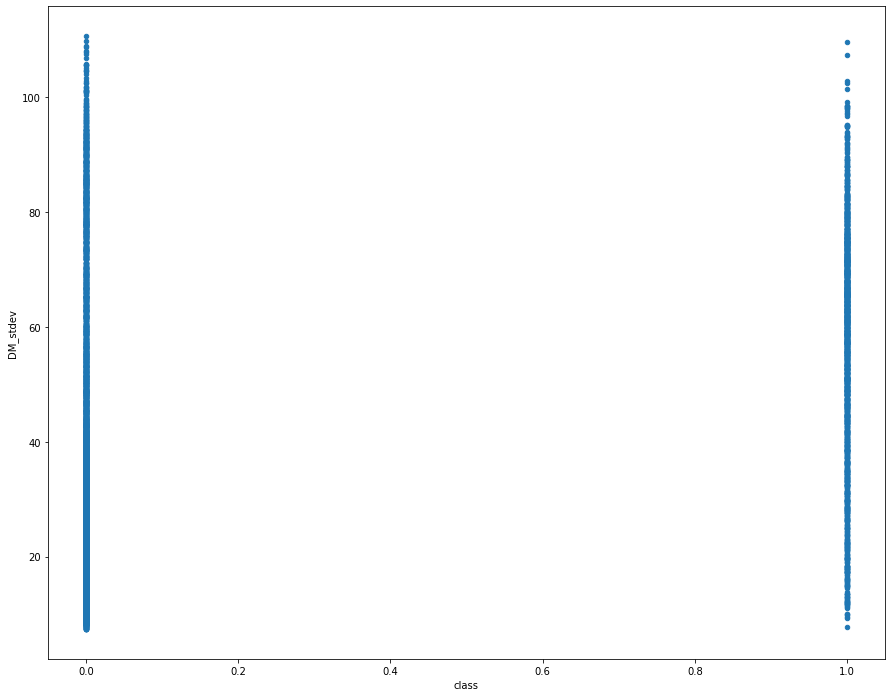

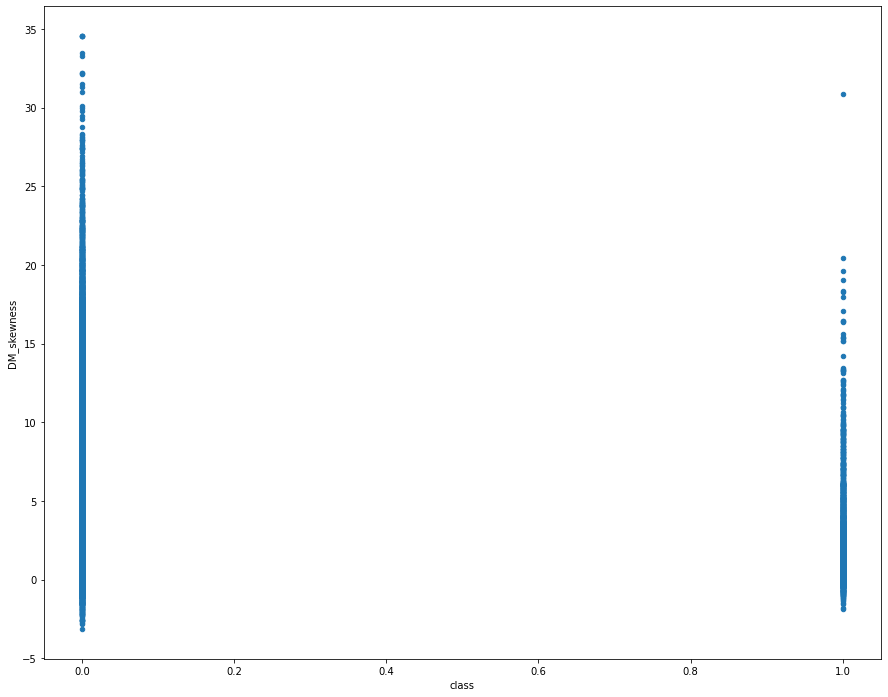

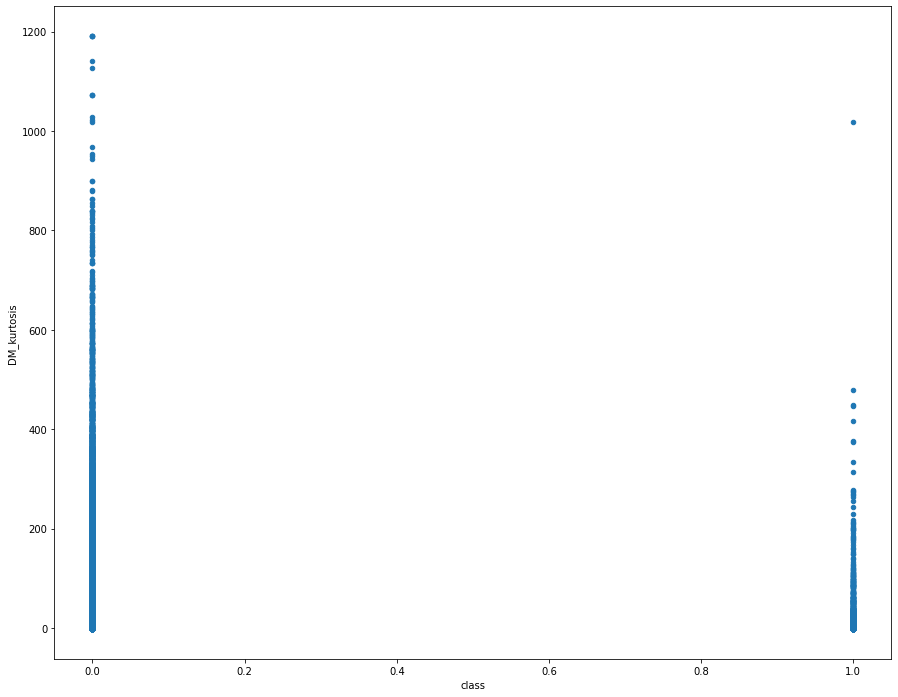

In [13]:
for column in dataset.columns:
    if (column != 'class'):
        dataset.plot(x='class', y=column, kind='scatter', figsize=(15,12))

<AxesSubplot:>

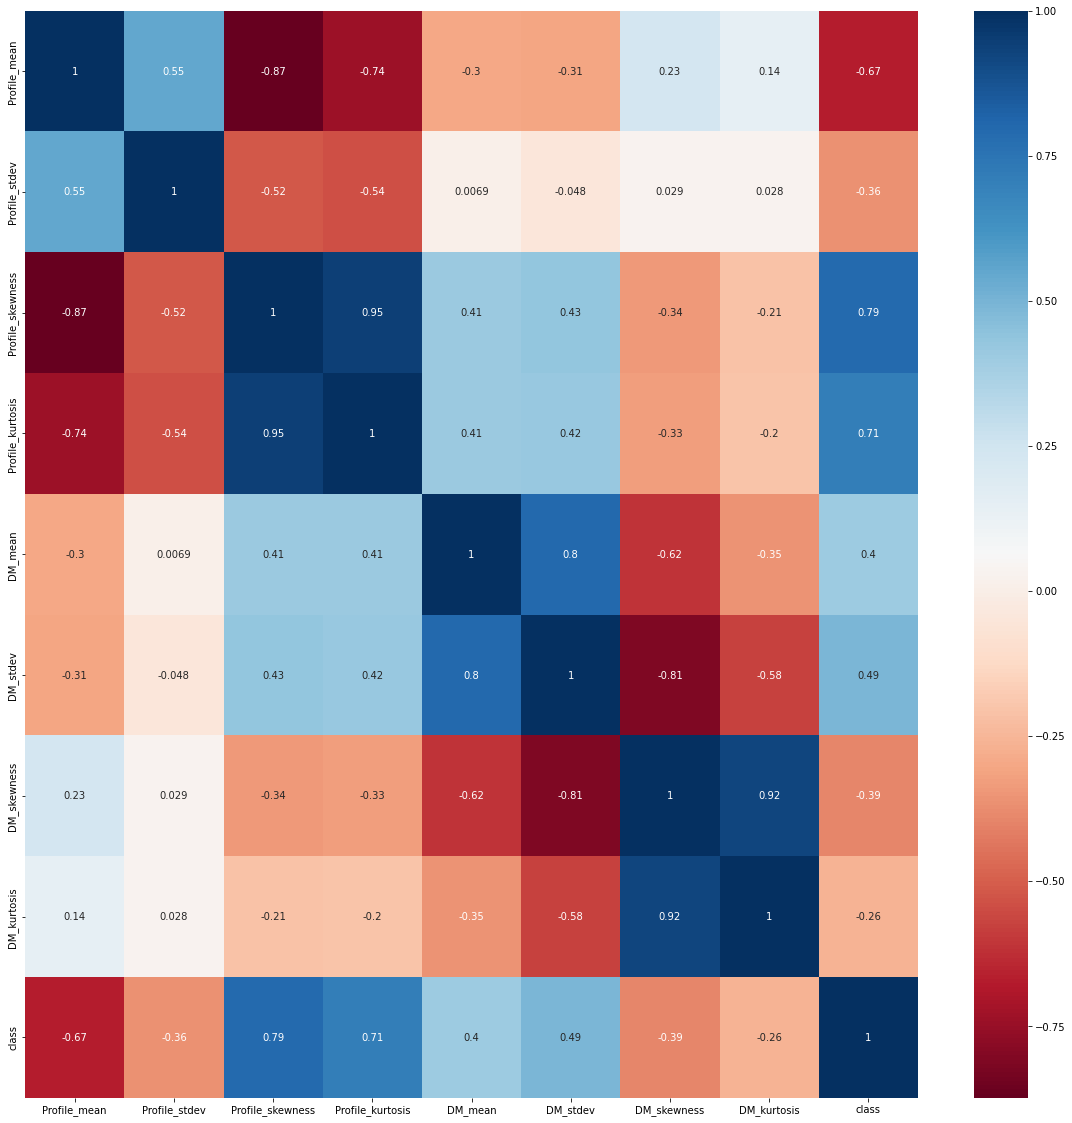

In [14]:
fig, ax = plt.subplots(figsize = (20,20))
sb.heatmap(dataset.corr(method='pearson'), annot=True, cmap='RdBu', ax=ax)

# Prepare Data

In [21]:
stdScaler = StandardScaler()
stadardizedData = stdScaler.fit_transform(datasetFeatures)
print("Mean:", round(stadardizedData[:,0].mean()))
print("Standard deviation:", stadardizedData[:,0].std())
stadardizedData


Mean: 0
Standard deviation: 1.0


array([[ 1.14931702,  1.33483164, -0.66956953, ..., -0.37062547,
        -0.07279778, -0.28743812],
       [-0.3341682 ,  1.80226533, -0.01178476, ..., -0.5889241 ,
         0.50442694,  0.21158145],
       [-0.31437216, -1.05332222, -0.14523256, ..., -0.23532816,
        -0.12599609, -0.39137346],
       ...,
       [ 0.3218423 ,  1.95621968, -0.2993338 , ...,  1.67156847,
        -1.28807874, -0.94133005],
       [ 0.13362759,  1.07450972, -0.26005007, ..., -0.66485697,
         0.37825656,  0.27584987],
       [-2.10576204,  5.73546965,  0.87267394, ...,  1.97154554,
        -2.19732744, -0.97105168]])

In [20]:
minmaxScaler = MinMaxScaler()
normalizedData = minmaxScaler.fit_transform(datasetFeatures)
print("Mean:", round(normalizedData[:,0].mean()))
print("Standard deviation:", normalizedData[:,0].std())
normalizedData

Mean: 1
Standard deviation: 0.13732106538995564


array([[0.72134164, 0.41768745, 0.16504291, ..., 0.11368057, 0.29498574,
        0.06388987],
       [0.51762787, 0.46090841, 0.23541516, ..., 0.0725243 , 0.36401483,
        0.10844339],
       [0.52034628, 0.19686832, 0.22113842, ..., 0.13918843, 0.28862387,
        0.05461031],
       ...,
       [0.60771193, 0.4751437 , 0.2046521 , ..., 0.49869934, 0.14965285,
        0.00550903],
       [0.58186609, 0.39361695, 0.20885482, ..., 0.05820853, 0.34892638,
        0.11418141],
       [0.27435072, 0.82458965, 0.33003783, ..., 0.5552546 , 0.04091771,
        0.00285542]])

In [18]:
datasetClass

0        0
1        0
2        0
3        0
4        0
        ..
17893    0
17894    0
17895    0
17896    0
17897    0
Name: class, Length: 17898, dtype: int64

In [19]:
datasetFeatures

,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306
...,...,...,...,...,...,...,...,...
17893,136.429688,59.847421,-0.187846,-0.738123,1.296823,12.166062,15.450260,285.931022
17894,122.554688,49.485605,0.127978,0.323061,16.409699,44.626893,2.945244,8.297092
17895,119.335938,59.935939,0.159363,-0.743025,21.430602,58.872000,2.499517,4.595173
17896,114.507812,53.902400,0.201161,-0.024789,1.946488,13.381731,10.007967,134.238910


In [25]:
# org
(x_train_org, x_test_org, y_train_org, y_test_org) = train_test_split(datasetFeatures, datasetClass, test_size=0.2)
(x_train_org, x_val_org, y_train_org, y_val_org) = train_test_split(x_train_org, y_train_org, test_size=0.1)

print('-------- Original -------------')
print("Shape of x_train:",x_train_org.shape)
print("Shape of x_test:",x_test_org.shape)
print("Shape of x_val:",x_val_org.shape)
print("Shape of y_train:",y_train_org.shape)
print("Shape of y_test:",y_test_org.shape)
print("Shape of y_val:",y_val_org.shape)
print('\n')
# std
(x_train_std, x_test_std, y_train_std, y_test_std) = train_test_split(datasetFeatures, datasetClass, test_size=0.2)
(x_train_std, x_val_std, y_train_std, y_val_std) = train_test_split(x_train_std, y_train_std, test_size=0.1)
print('-------- Standardized -------------')
print("Shape of x_train:",x_train_std.shape)
print("Shape of x_test:",x_test_std.shape)
print("Shape of x_val:",x_val_std.shape)
print("Shape of y_train:",y_train_std.shape)
print("Shape of y_test:",y_test_std.shape)
print("Shape of y_val:",y_val_std.shape)
print('\n')
# normalized
(x_train_norm, x_test_norm, y_train_norm, y_test_norm) = train_test_split(datasetFeatures, datasetClass, test_size=0.2)
(x_train_norm, x_val_norm, y_train_norm, y_val_norm) = train_test_split(x_train_norm, y_train_norm, test_size=0.1)

print('-------- Normalized -------------')
print("Shape of x_train:",x_train_norm.shape)
print("Shape of x_test:",x_test_norm.shape)
print("Shape of x_val:",x_val_norm.shape)
print("Shape of y_train:",y_train_norm.shape)
print("Shape of y_test:",y_test_norm.shape)
print("Shape of y_val:",y_val_norm.shape)

-------- Original -------------
Shape of x_train: (12886, 8)
Shape of x_test: (3580, 8)
Shape of x_val: (1432, 8)
Shape of y_train: (12886,)
Shape of y_test: (3580,)
Shape of y_val: (1432,)


-------- Standardized -------------
Shape of x_train: (12886, 8)
Shape of x_test: (3580, 8)
Shape of x_val: (1432, 8)
Shape of y_train: (12886,)
Shape of y_test: (3580,)
Shape of y_val: (1432,)


-------- Normalized -------------
Shape of x_train: (12886, 8)
Shape of x_test: (3580, 8)
Shape of x_val: (1432, 8)
Shape of y_train: (12886,)
Shape of y_test: (3580,)
Shape of y_val: (1432,)


# Models

In [118]:
def plotLossEpochs(model):
    
    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['val_loss'])
    plt.title("Model's Training & Validation loss across epochs")
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

    return

In [119]:
def plotAccEpochs(model):

    plt.plot(model.history.history['accuracy'])
    plt.plot(model.history.history['val_accuracy'])
    plt.title("Model's Training & Validation Accuracy across epochs")
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Accuracy'], loc='upper right')
    plt.show()

    return

In [94]:
def checkAccuracy(y, prediction):
    guesses = 0
    ind = 0
    for a in prediction:
        if (a[0] == y[ind]):
            guesses += 1
        
        ind += 1
    
    return (guesses * 1.0) / len(prediction)

In [101]:
model_start = Sequential()
model_start.add(Dense(32, input_dim=x_test_org.shape[1], activation='relu'))
model_start.add(Dropout(rate=0.25))
model_start.add(Dense(1, activation='sigmoid'))

model_start.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

In [102]:
model_start.fit(x_train_org, y_train_org, validation_data=(x_val_org, y_val_org), epochs=5, batch_size=32)

Epoch 1/5
403/403 [==============================] - 2s 4ms/step - loss: 0.3478 - accuracy: 0.9517 - val_loss: 0.1652 - val_accuracy: 0.9553
Epoch 2/5
403/403 [==============================] - 1s 3ms/step - loss: 0.1318 - accuracy: 0.9651 - val_loss: 0.1003 - val_accuracy: 0.9714
Epoch 3/5
403/403 [==============================] - 1s 3ms/step - loss: 0.1130 - accuracy: 0.9677 - val_loss: 0.1152 - val_accuracy: 0.9679
Epoch 4/5
403/403 [==============================] - 1s 3ms/step - loss: 0.1095 - accuracy: 0.9699 - val_loss: 0.1024 - val_accuracy: 0.9707
Epoch 5/5
403/403 [==============================] - 1s 3ms/step - loss: 0.1039 - accuracy: 0.9707 - val_loss: 0.0969 - val_accuracy: 0.9721


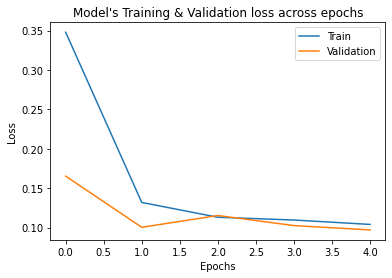

In [121]:
plotLossEpochs(model_start)

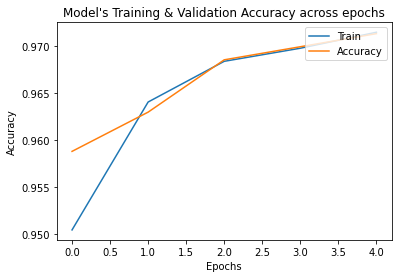

In [56]:
plotAccEpochs(model_start)

In [95]:
y_pred_org_start = (model_start.predict(x_test_org) > 0.5).astype("int64")
checkAccuracy(y_test_org.tolist(), y_pred_org_start)


0.9653631284916201

In [127]:
confusion_matrix(y_test_org.tolist(), y_pred_org_start)

array([[3233,   20],
       [ 104,  223]], dtype=int64)

In [47]:
model_start.fit(x_train_std, y_train_std, validation_data=(x_val_std, y_val_std), epochs=5, batch_size=32)

Epoch 1/5
403/403 [==============================] - 1s 2ms/step - loss: 0.1054 - accuracy: 0.9701 - val_loss: 0.0824 - val_accuracy: 0.9770
Epoch 2/5
403/403 [==============================] - 1s 2ms/step - loss: 0.1032 - accuracy: 0.9717 - val_loss: 0.0794 - val_accuracy: 0.9763
Epoch 3/5
403/403 [==============================] - 1s 2ms/step - loss: 0.1028 - accuracy: 0.9715 - val_loss: 0.0844 - val_accuracy: 0.9797
Epoch 4/5
403/403 [==============================] - 1s 2ms/step - loss: 0.0998 - accuracy: 0.9712 - val_loss: 0.0783 - val_accuracy: 0.9770
Epoch 5/5
403/403 [==============================] - 1s 2ms/step - loss: 0.0998 - accuracy: 0.9715 - val_loss: 0.0796 - val_accuracy: 0.9770


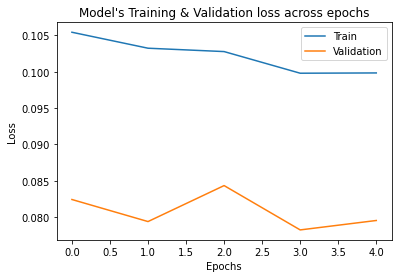

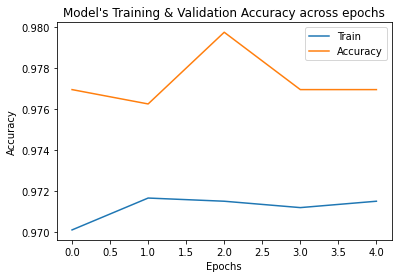

In [48]:
plotLossEpochs(model_start)
plotAccEpochs(model_start)

In [49]:
model_start.fit(x_train_norm, y_train_norm, validation_data=(x_val_norm, y_val_norm), epochs=5, batch_size=32)

Epoch 1/5
403/403 [==============================] - 1s 2ms/step - loss: 0.0983 - accuracy: 0.9741 - val_loss: 0.0947 - val_accuracy: 0.9679
Epoch 2/5
403/403 [==============================] - 1s 2ms/step - loss: 0.0989 - accuracy: 0.9737 - val_loss: 0.0953 - val_accuracy: 0.9721
Epoch 3/5
403/403 [==============================] - 1s 2ms/step - loss: 0.0955 - accuracy: 0.9746 - val_loss: 0.0973 - val_accuracy: 0.9700
Epoch 4/5
403/403 [==============================] - 1s 2ms/step - loss: 0.0981 - accuracy: 0.9741 - val_loss: 0.0946 - val_accuracy: 0.9700
Epoch 5/5
403/403 [==============================] - 1s 2ms/step - loss: 0.0971 - accuracy: 0.9734 - val_loss: 0.0951 - val_accuracy: 0.9700


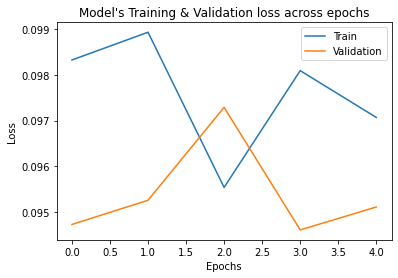

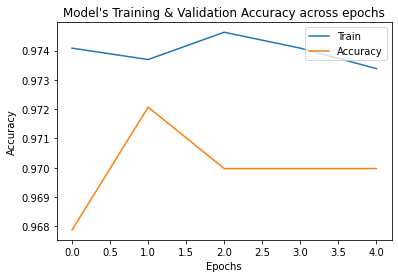

In [50]:
plotLossEpochs(model_start)
plotAccEpochs(model_start)

In [96]:
model2 = Sequential()
model2.add(Dense(32, input_dim=x_test_org.shape[1], activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [97]:
model2.fit(x_train_org, y_train_org, validation_data=(x_val_org, y_val_org), epochs=5, batch_size=32)

Epoch 1/5
403/403 [==============================] - 3s 5ms/step - loss: 0.6918 - accuracy: 0.9374 - val_loss: 0.1178 - val_accuracy: 0.9672
Epoch 2/5
403/403 [==============================] - 1s 3ms/step - loss: 0.1005 - accuracy: 0.9735 - val_loss: 0.0960 - val_accuracy: 0.9728
Epoch 3/5
403/403 [==============================] - 1s 3ms/step - loss: 0.1003 - accuracy: 0.9735 - val_loss: 0.0982 - val_accuracy: 0.9728
Epoch 4/5
403/403 [==============================] - 1s 3ms/step - loss: 0.0984 - accuracy: 0.9755 - val_loss: 0.1020 - val_accuracy: 0.9728
Epoch 5/5
403/403 [==============================] - 1s 3ms/step - loss: 0.0990 - accuracy: 0.9749 - val_loss: 0.1051 - val_accuracy: 0.9707


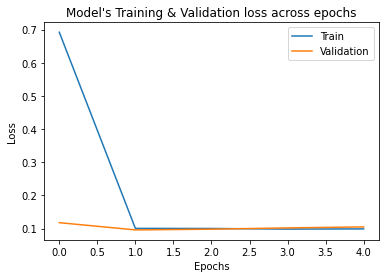

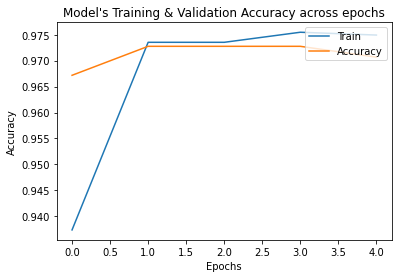

In [98]:
plotLossEpochs(model2)
plotAccEpochs(model2)

In [125]:
y_pred_org_model2 = (model2.predict(x_test_org) > 0.5).astype("int64")
checkAccuracy(y_test_org.tolist(), y_pred_org_model2)

0.9740223463687151

In [126]:
confusion_matrix(y_test_org.tolist(), y_pred_org_model2)

array([[3217,   36],
       [  57,  270]], dtype=int64)

In [123]:
model3 = Sequential()
model3.add(Dense(32, input_dim=x_test_org.shape[1], activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [128]:
y_pred_org_model3 = (model3.predict(x_test_org) > 0.5).astype("int64")
checkAccuracy(y_test_org.tolist(), y_pred_org_model3)

0.908659217877095

In [129]:
confusion_matrix(y_test_org.tolist(), y_pred_org_model3)

array([[3253,    0],
       [ 327,    0]], dtype=int64)